In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import numpy as np
from numpy.linalg import slogdet
import matplotlib.pyplot as plt

#bempp.api.enable_console_logging()

Setting the size of the element of the mesh and the center of the two spheres. The radius of the sphere is 1 and the distance between the boundary of them if 1. (Z/R=1)

In [5]:
center1 = (1.5, 0, 0) # center of one sphere
center2 = (-1.5, 0, 0) 

Construct RWG and SNC in difference spaces.

We are defining an exponentially adapted trapezoid rule and choose the quadrature points accordingly.

In [8]:
#size_mesh = [0.4, 0.375, 0.35, 0.325, 0.3, 0.275, 0.25, 0.225 0.2, 0.175, 0.15, 0.125, 0.1, 0.075, 0.05, 0.025]
size_mesh = [0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05]
result_2j = []

for index, h in enumerate(size_mesh):
    sphere1 = bempp.api.shapes.sphere(h=h, origin=center1) # construct the spheres
    sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)
    
    rwg1 = bempp.api.function_space(sphere1, "RWG", 0)
    rwg2 = bempp.api.function_space(sphere2, "RWG", 0)

    snc1 = bempp.api.function_space(sphere1, "SNC", 0)
    snc2 = bempp.api.function_space(sphere2, "SNC", 0)
    
    wavenumber = 1j * 2

    op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg1, snc1, wavenumber)
    op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg2, snc2, wavenumber)
    op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1, rwg2, snc2, wavenumber)
    op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2, rwg1, snc1, wavenumber)

    blocked_op = BlockedOperator(2, 2)
    blocked_op[0, 0] = op11
    blocked_op[0, 1] = op12
    blocked_op[1, 0] = op21
    blocked_op[1, 1] = op22

    blocked_diag = BlockedOperator(2, 2)
    blocked_diag[0, 0] = op11
    blocked_diag[1, 1] = op22

    mat = np.real(bempp.api.as_matrix(blocked_op.weak_form()))
    mat2 = np.real(bempp.api.as_matrix(blocked_diag.weak_form()))
    combined = np.linalg.inv(mat2).dot(mat)
    sign, logdet = slogdet(combined)
    result_2j.append(logdet)

In [9]:
%matplotlib inline
from matplotlib.pyplot import figure

The left plot shows the relative log determinant with increasing imaginary wavenumber. The right plot uses a scale appropriate for the trapezoid quadrature rule.

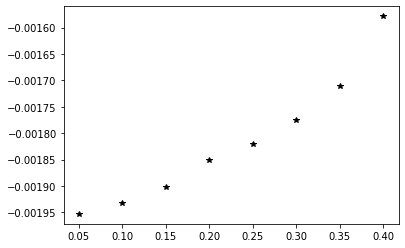

In [11]:
plt.plot(size_mesh,result_2j,'k*')

In [28]:
rate_conv = [] #linearly convergence
for i in range(6):
    rate_conv.append(abs((result_2j[i+2]-result_2j[0]))/abs((result_2j[i+1]-result_2j[0])))

In [29]:
rate_conv

[1.4899860174345836,
 1.2301643110143032,
 1.1254133507610988,
 1.1880365965481663,
 1.0920006299014156,
 1.0607262284007763]